In [1]:
import pandas as pd 

from helpers import *
from clustering_helpers import *

from tslearn.metrics import cdist_dtw 

import warnings
warnings.filterwarnings("ignore")


RSEED = 2


c:\Users\Maria\Desktop\Work\Projects\MIMIC\Representation-Clustering\.venv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
import gc

gc.collect()

21

In [3]:
# reading demographics and storing patients sets

demographics = pd.read_hdf('C:\\Users\\\Maria\\Desktop\\Work\\Projects\\MIMIC\\Representation-Clustering\\patient_clustering_EHR\\data\\data_icu.h5', key='demographics') 

labs_vitals = pd.read_hdf('C:\\Users\\Maria\\Desktop\\Work\\Projects\\MIMIC\\Representation-Clustering\\labs_vitals.h5', key='preprocessed') 
labs = labs_vitals.reset_index()

#storing the true labels
true_labels = demographics[demographics.subject_id.isin(labs.subject_id)][['subject_id', 'hadm_id', 'icustay_id', 'mort_icu']]
del labs 


In [4]:
labs_vitals.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 777504 entries, (3, 131072, 262156) to (99995, 131059, 262140)
Columns: 106 entries, Alanine aminotransferase to pH urine
dtypes: float64(104), int64(2)
memory usage: 635.1 MB


In [5]:
demographics.set_index("subject_id", inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
demo_train, demo_test, y_train, y_test = train_test_split(demographics, demographics.mort_icu, test_size=0.90, random_state=42)


In [7]:
labs_vitals = labs_vitals.reset_index()
demo_train = demo_train.reset_index()
demo_test = demo_test.reset_index()
labs_train = labs_vitals[labs_vitals.subject_id.isin(demo_train.subject_id)]
labs_test = labs_vitals[labs_vitals.subject_id.isin(demo_test.subject_id)]


In [8]:
labs_train = labs_train.set_index(['subject_id','hadm_id', 'icustay_id'])
for column_name in labs_train.columns:
    column = labs_train[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()/labs_train.shape[0]
    #np.sum(np.isnan(labs_vitals), axis=0)/labs_vitals.shape[0]
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  Alanine aminotransferase  is :  0.8161517444304329
Count of zeros in column  Albumin  is :  0.8532471626733922
Count of zeros in column  Albumin ascites  is :  0.9990804960067255
Count of zeros in column  Albumin pleural  is :  0.9983186212694409
Count of zeros in column  Albumin urine  is :  0.9993957545187053
Count of zeros in column  Alkaline phosphate  is :  0.8196852669188734
Count of zeros in column  Asparate aminotransferase  is :  0.8162568306010929
Count of zeros in column  Basophils  is :  0.9124500840689366
Count of zeros in column  Bilirubin  is :  0.8131830601092896
Count of zeros in column  CO2 (ETCO2, PCO2, etc.)  is :  0.584817675493905
Count of zeros in column  Calcium ionized  is :  0.6578525641025641
Count of zeros in column  Calcium urine  is :  0.9992775325767129
Count of zeros in column  Cardiac Index  is :  0.9103614964270702
Count of zeros in column  Cardiac Output Thermodilution  is :  0.9266104455653636
Count of zeros in column  Cardi

In [9]:
labs_train = drop_recordings(labs_train, 0.9)
labs_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 76128 entries, (64, 131186, 262265) to (99936, 131013, 262085)
Data columns (total 65 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Alanine aminotransferase                   76128 non-null  float64
 1   Albumin                                    76128 non-null  float64
 2   Alkaline phosphate                         76128 non-null  float64
 3   Asparate aminotransferase                  76128 non-null  float64
 4   Bilirubin                                  76128 non-null  float64
 5   CO2 (ETCO2, PCO2, etc.)                    76128 non-null  float64
 6   Calcium ionized                            76128 non-null  float64
 7   Central Venous Pressure                    76128 non-null  float64
 8   Fraction inspired oxygen                   76128 non-null  float64
 9   Lactate                                    76128 non-null

In [16]:
def pre_eucl(df, columnA, columnW):
    hours_in_ = df.hours_in_
    df = df.drop(['hours_in', 'hours_in_'], axis=1)

    out = to_3d_numpy(df, columnA, columnW)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(out.reshape(-1, out.shape[-1])).reshape(out.shape)

    m,n,r = X_train.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),X_train.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr, columns = df.columns.insert(0, 'drop-it'), index=df.index)
    out_df.drop('drop-it', axis=1, inplace=True)

    return out_df, X_train, hours_in_



In [17]:
columnA = 'Alanine aminotransferase'
columnW = 'pH urine'
Xtrain_dict = {}
labs_vitals_reduced = cut_time_series(labs_train, 8)
Xtrain_dict["Xtrain_8"] = labs_vitals_reduced
#out = to_3d_numpy(labs_vitals_reduced, 'Alanine aminotransferase', 'pH urine')
#Xtrain_dict["Xtrain_8_np"] = out

df_8, X_train_8, hours_in_8 = pre_eucl(Xtrain_dict["Xtrain_8"], columnA, columnW)

labs_vitals_reduced = cut_time_series(labs_train, 16)
Xtrain_dict["Xtrain_16"] = labs_vitals_reduced
#out = to_3d_numpy(labs_vitals_reduced, 'Alanine aminotransferase', 'pH urine')
#Xtrain_dict["Xtrain_16_np"] = out
df_16, X_train_16, hours_in_16 = pre_eucl(Xtrain_dict["Xtrain_16"],columnA, columnW)

labs_vitals_reduced = cut_time_series(labs_train, 24)
Xtrain_dict["Xtrain_24"] = labs_vitals_reduced
#out = to_3d_numpy(labs_vitals_reduced, 'Alanine aminotransferase', 'pH urine')
#Xtrain_dict["Xtrain_24_np"] = out
df_24, X_train_24, hours_in_24 = pre_eucl(Xtrain_dict["Xtrain_24"], columnA, columnW)

labs_vitals_reduced = cut_time_series(labs_train, 32)
Xtrain_dict["Xtrain_32"] = labs_vitals_reduced
#out = to_3d_numpy(labs_vitals_reduced, 'Alanine aminotransferase', 'pH urine')
df_32, X_train_32, hours_in_32 = pre_eucl(Xtrain_dict["Xtrain_32"], columnA, columnW)
#Xtrain_dict["Xtrain_32_np"] = out

labs_vitals_reduced = cut_time_series(labs_train, 40)
Xtrain_dict["Xtrain_40"] = labs_vitals_reduced
#out = to_3d_numpy(labs_vitals_reduced, 'Alanine aminotransferase', 'ppH urine')
df_40, X_train_40, hours_in_40 = pre_eucl(Xtrain_dict["Xtrain_40"], columnA, columnW)
#Xtrain_dict["Xtrain_40_np"] = out

Xtrain_dict["Xtrain_48"] = labs_train
#out = to_3d_numpy(labs_train, 'Alanine aminotransferase', 'pH')
df_48, X_train_48, hours_in_48 = pre_eucl(Xtrain_dict["Xtrain_48"], columnA, columnW)

#Xtrain_dict["Xtrain_48_np"] = out

cutting the series....
24586
range(0, 8)
73740
range(0, 8)
16399
range(0, 8)
24594
range(0, 8)
32793
range(0, 8)
57371
range(0, 8)
73765
range(0, 8)
24614
range(0, 8)
98347
range(0, 8)
49209
range(0, 8)
64
range(0, 8)
24647
range(0, 8)
8272
range(0, 8)
73808
range(0, 8)
82000
range(0, 8)
82003
range(0, 8)
8288
range(0, 8)
98
range(0, 8)
16490
range(0, 8)
65646
range(0, 8)
16518
range(0, 8)
82055
range(0, 8)
57489
range(0, 8)
149
range(0, 8)
8347
range(0, 8)
8348
range(0, 8)
16543
range(0, 8)
16551
range(0, 8)
24756
range(0, 8)
24759
range(0, 8)
16568
range(0, 8)
24761
range(0, 8)
186
range(0, 8)
16575
range(0, 8)
16579
range(0, 8)
82115
range(0, 8)
24777
range(0, 8)
209
range(0, 8)
16594
range(0, 8)
214
range(0, 8)
90327
range(0, 8)
8410
range(0, 8)
57562
range(0, 8)
73953
range(0, 8)
24807
range(0, 8)
16619
range(0, 8)
243
range(0, 8)
24820
range(0, 8)
245
range(0, 8)
41205
range(0, 8)
16633
range(0, 8)
8443
range(0, 8)
16635
range(0, 8)
8445
range(0, 8)
73993
range(0, 8)
8467
range(0

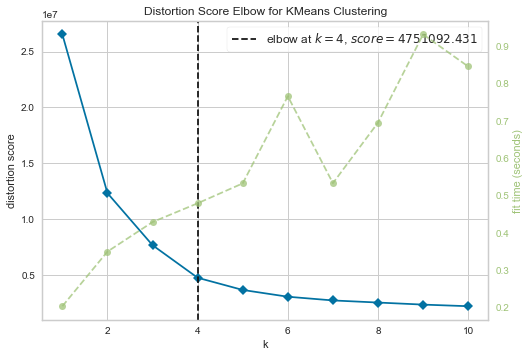

Clustering Algorithm: 8 windows kmeans
Silhouette Score:  0.479 Purity:  0.93
Clustering Algorithm: 8 windows ward
Silhouette Score:  0.452 Purity:  0.93
Clustering Algorithm: 8 windows complete
Silhouette Score:  0.594 Purity:  0.93
Clustering Algorithm: 8 windows single
Silhouette Score:  0.781 Purity:  0.93
Clustering Algorithm: 8 windows spectral
Silhouette Score:  0.097 Purity:  0.93


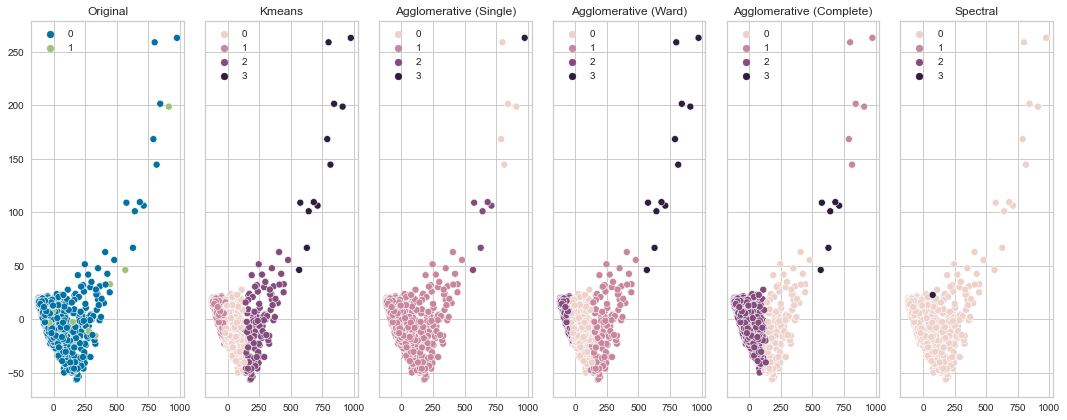

#######################################################################
############################ Next Window ##############################


In [19]:

df_8['hours_in'] = hours_in_8
pairwise_euclidean_8 = calc_euclideans(df_8, columnA, columnW)
#pairwise_euclidean = cdist_dtw(X_train_16)


number_of_clusters = elbow_method(pairwise_euclidean_8,10)
#kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean, number_of_clusters)

kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean_8, number_of_clusters)
for keys, values in labels_dict.items():
    print("Clustering Algorithm: 8 windows", keys)
    s_s, pu = evaluation_metrics(pairwise_euclidean_8, values, y_train[y_train.index.isin(df_8.reset_index().subject_id)].values, 'euclidean', rseed = RSEED)
    print("Silhouette Score: ", np.round(s_s, decimals=3) , "Purity: ", np.round(pu, decimals=3))
plot_clusters(pairwise_euclidean_8, kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, y_train[y_train.index.isin(df_8.reset_index().subject_id)].values)
print("#######################################################################")
print("############################ Next Window ##############################")

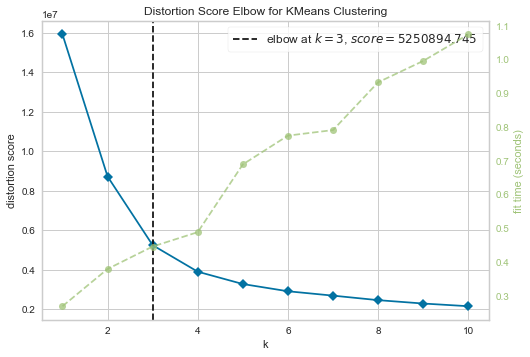

Clustering Algorithm: 16 windows kmeans
Silhouette Score:  0.496 Purity:  0.93
Clustering Algorithm: 16 windows ward
Silhouette Score:  0.468 Purity:  0.93
Clustering Algorithm: 16 windows complete
Silhouette Score:  0.59 Purity:  0.93
Clustering Algorithm: 16 windows single
Silhouette Score:  0.873 Purity:  0.93
Clustering Algorithm: 16 windows spectral
Silhouette Score:  -0.192 Purity:  0.93


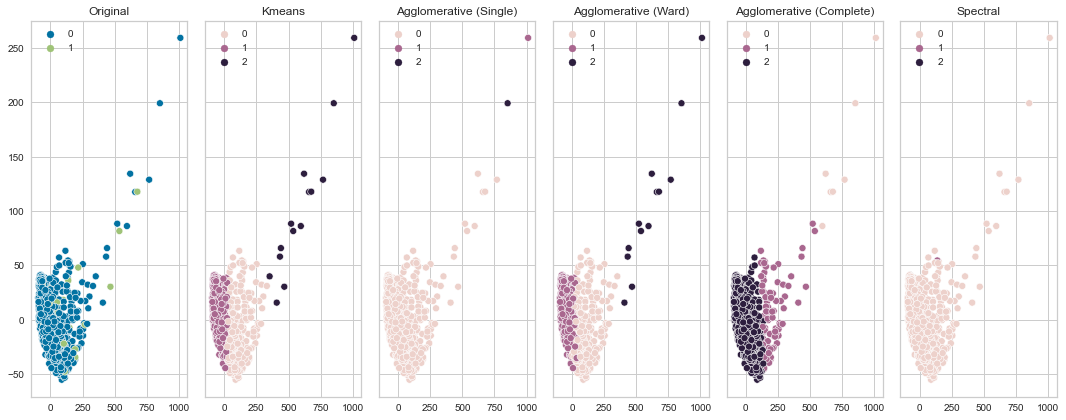

#######################################################################
############################ Next Window ##############################


In [21]:

df_16['hours_in'] = hours_in_16
pairwise_euclidean_16 = calc_euclideans(df_16, columnA, columnW)
#pairwise_euclidean = cdist_dtw(X_train_16)


number_of_clusters = elbow_method(pairwise_euclidean_16,10)
#kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean, number_of_clusters)

kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean_16, number_of_clusters)
for keys, values in labels_dict.items():
    print("Clustering Algorithm: 16 windows", keys)
    s_s, pu = evaluation_metrics(pairwise_euclidean_16, values, y_train[y_train.index.isin(df_16.reset_index().subject_id)].values, 'euclidean', rseed = RSEED)
    print("Silhouette Score: ", np.round(s_s, decimals=3) , "Purity: ", np.round(pu, decimals=3))
plot_clusters(pairwise_euclidean_16, kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, y_train[y_train.index.isin(df_16.reset_index().subject_id)].values)
print("#######################################################################")
print("############################ Next Window ##############################")

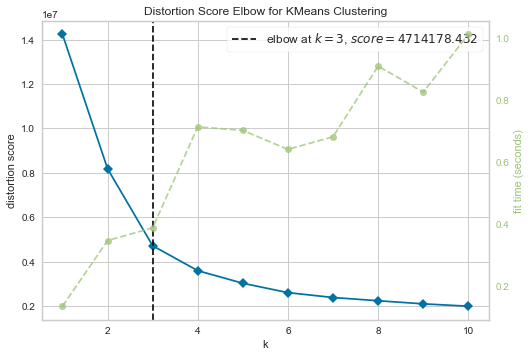

Clustering Algorithm: 24 windows kmeans
Silhouette Score:  0.469 Purity:  0.93
Clustering Algorithm: 24 windows ward
Silhouette Score:  0.466 Purity:  0.93
Clustering Algorithm: 24 windows complete
Silhouette Score:  0.637 Purity:  0.93
Clustering Algorithm: 24 windows single
Silhouette Score:  0.867 Purity:  0.93
Clustering Algorithm: 24 windows spectral
Silhouette Score:  -0.107 Purity:  0.93


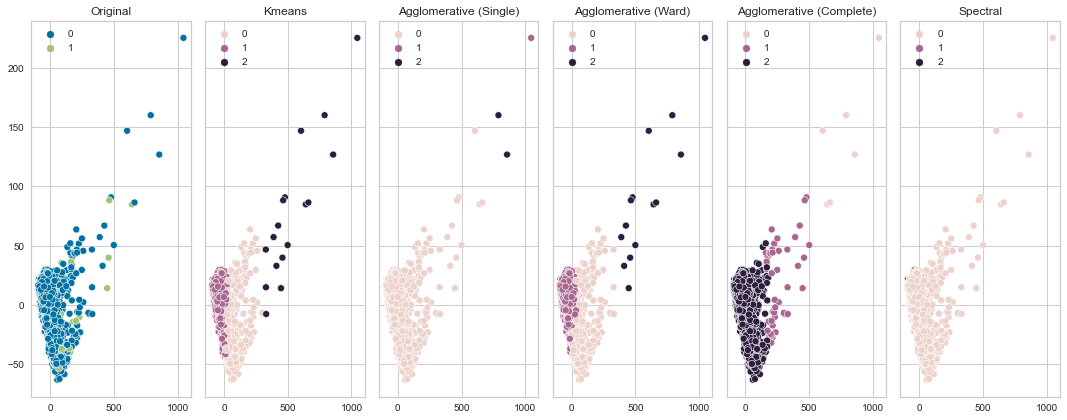

#######################################################################
############################ Next Window ##############################


In [22]:
df_24['hours_in'] = hours_in_24
pairwise_euclidean_24 = calc_euclideans(df_24, columnA, columnW)
#pairwise_euclidean = cdist_dtw(X_train_16)


number_of_clusters = elbow_method(pairwise_euclidean_24,10)
#kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean, number_of_clusters)

kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean_24, number_of_clusters)
for keys, values in labels_dict.items():
    print("Clustering Algorithm: 24 windows", keys)
    s_s, pu = evaluation_metrics(pairwise_euclidean_16, values, y_train[y_train.index.isin(df_24.reset_index().subject_id)].values, 'euclidean', rseed = RSEED)
    print("Silhouette Score: ", np.round(s_s, decimals=3) , "Purity: ", np.round(pu, decimals=3))
plot_clusters(pairwise_euclidean_24, kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, y_train[y_train.index.isin(df_24.reset_index().subject_id)].values)
print("#######################################################################")
print("############################ Next Window ##############################")

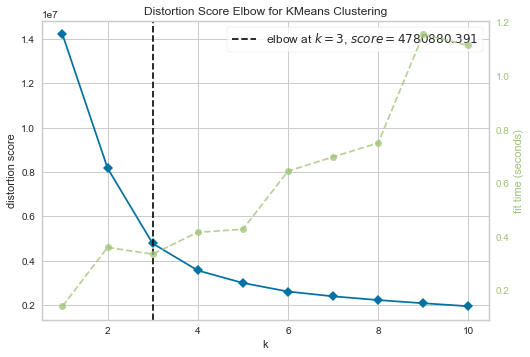

Clustering Algorithm: 32 windows kmeans
Silhouette Score:  0.479 Purity:  0.93
Clustering Algorithm: 32 windows ward
Silhouette Score:  0.435 Purity:  0.93
Clustering Algorithm: 32 windows complete
Silhouette Score:  0.76 Purity:  0.93
Clustering Algorithm: 32 windows single
Silhouette Score:  0.853 Purity:  0.93
Clustering Algorithm: 32 windows spectral
Silhouette Score:  -0.13 Purity:  0.93


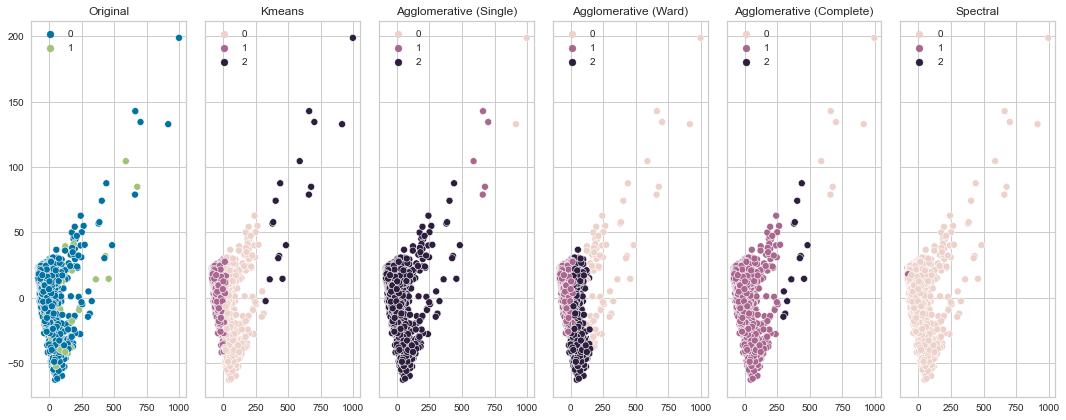

#######################################################################
############################ Next Window ##############################


In [23]:
df_32['hours_in'] = hours_in_32
pairwise_euclidean_32 = calc_euclideans(df_32, columnA, columnW)
#pairwise_euclidean = cdist_dtw(X_train_16)


number_of_clusters = elbow_method(pairwise_euclidean_32,10)
#kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean, number_of_clusters)

kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean_32, number_of_clusters)
for keys, values in labels_dict.items():
    print("Clustering Algorithm: 32 windows", keys)
    s_s, pu = evaluation_metrics(pairwise_euclidean_32, values, y_train[y_train.index.isin(df_32.reset_index().subject_id)].values, 'euclidean', rseed = RSEED)
    print("Silhouette Score: ", np.round(s_s, decimals=3) , "Purity: ", np.round(pu, decimals=3))
plot_clusters(pairwise_euclidean_32, kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, y_train[y_train.index.isin(df_32.reset_index().subject_id)].values)
print("#######################################################################")
print("############################ Next Window ##############################")

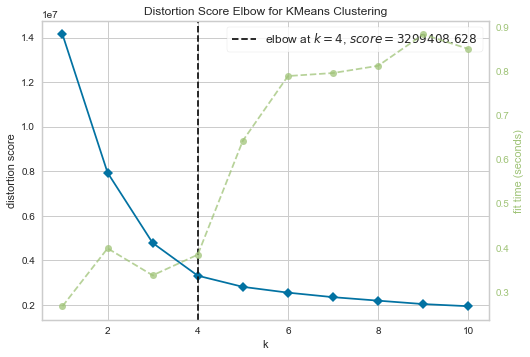

Clustering Algorithm: 40 windows kmeans
Silhouette Score:  0.436 Purity:  0.93
Clustering Algorithm: 40 windows ward
Silhouette Score:  0.443 Purity:  0.93
Clustering Algorithm: 40 windows complete
Silhouette Score:  0.554 Purity:  0.93
Clustering Algorithm: 40 windows single
Silhouette Score:  0.84 Purity:  0.931
Clustering Algorithm: 40 windows spectral
Silhouette Score:  -0.213 Purity:  0.93


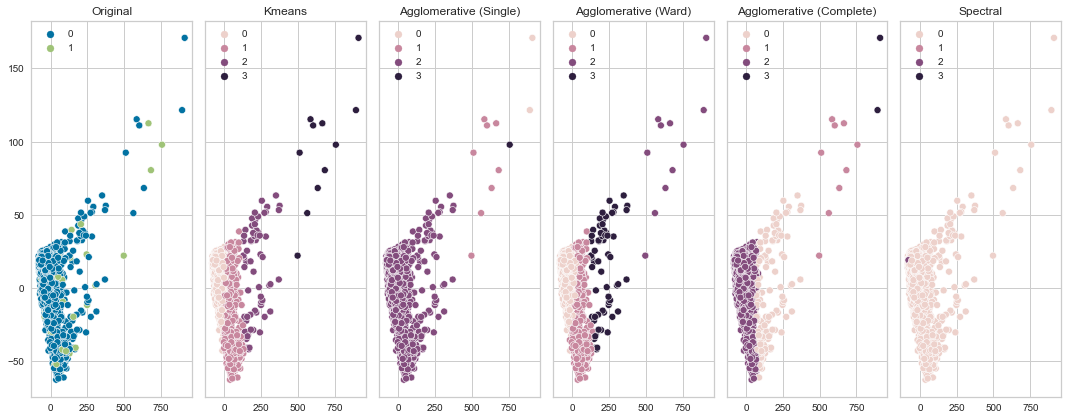

#######################################################################
############################ Next Window ##############################


In [24]:
df_40['hours_in'] = hours_in_40
pairwise_euclidean_40 = calc_euclideans(df_40, columnA, columnW)
#pairwise_euclidean = cdist_dtw(X_train_16)


number_of_clusters = elbow_method(pairwise_euclidean_40,10)
#kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean, number_of_clusters)

kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean_40, number_of_clusters)
for keys, values in labels_dict.items():
    print("Clustering Algorithm: 40 windows", keys)
    s_s, pu = evaluation_metrics(pairwise_euclidean_40, values, y_train[y_train.index.isin(df_40.reset_index().subject_id)].values, 'euclidean', rseed = RSEED)
    print("Silhouette Score: ", np.round(s_s, decimals=3) , "Purity: ", np.round(pu, decimals=3))
plot_clusters(pairwise_euclidean_40, kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, y_train[y_train.index.isin(df_40.reset_index().subject_id)].values)
print("#######################################################################")
print("############################ Next Window ##############################")

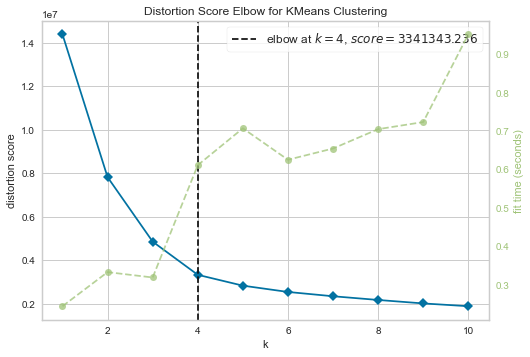

Clustering Algorithm: 48 windows kmeans
Silhouette Score:  0.436 Purity:  0.93
Clustering Algorithm: 48 windows ward
Silhouette Score:  0.429 Purity:  0.93
Clustering Algorithm: 48 windows complete
Silhouette Score:  0.645 Purity:  0.93
Clustering Algorithm: 48 windows single
Silhouette Score:  0.839 Purity:  0.931
Clustering Algorithm: 48 windows spectral
Silhouette Score:  -0.193 Purity:  0.93


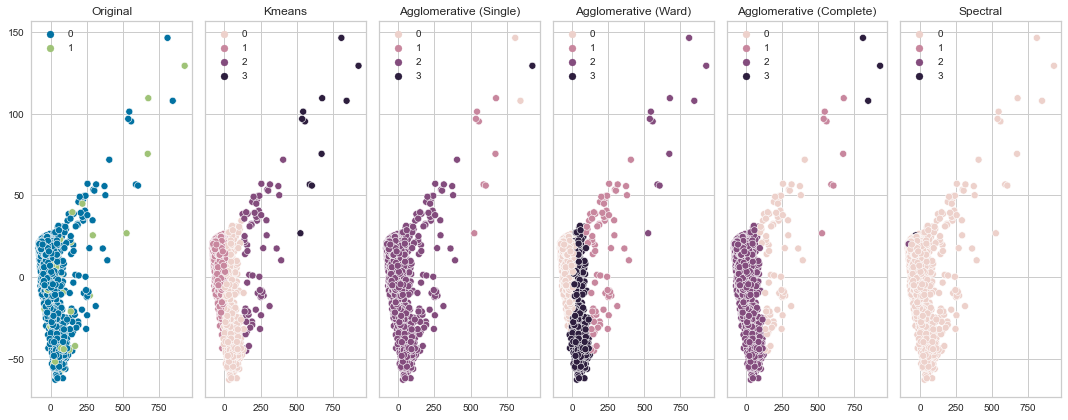

#######################################################################
############################ Next Window ##############################


In [25]:
df_48['hours_in'] = hours_in_48
pairwise_euclidean_48 = calc_euclideans(df_48, columnA, columnW)
#pairwise_euclidean = cdist_dtw(X_train_16)


number_of_clusters = elbow_method(pairwise_euclidean_48,10)
#kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean, number_of_clusters)

kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, labels_dict = run_algos(pairwise_euclidean_48, number_of_clusters)
for keys, values in labels_dict.items():
    print("Clustering Algorithm: 48 windows", keys)
    s_s, pu = evaluation_metrics(pairwise_euclidean_48, values, y_train[y_train.index.isin(df_48.reset_index().subject_id)].values, 'euclidean', rseed = RSEED)
    print("Silhouette Score: ", np.round(s_s, decimals=3) , "Purity: ", np.round(pu, decimals=3))
plot_clusters(pairwise_euclidean_48, kmeans_labels, ward_labels, complete_labels, single_labels, spectral_labels, y_train[y_train.index.isin(df_48.reset_index().subject_id)].values)
print("#######################################################################")
print("############################ Next Window ##############################")